<a href="https://colab.research.google.com/github/larissavaladao/py6s_harmonize_sample/blob/main/6.%20parameters_by_period/area_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import geopandas as gpd
import pandas as pd
import math
import ee
import geemap

In [2]:
ee.Authenticate()
ee.Initialize(project='ee-curuai')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import image collections

Landsat 7 - PY6S

In [4]:
landsat7 = ee.ImageCollection("projects/ee-curuai/assets/Py6S/LD7/ld7_py6s")\
            .select([ 'B1', 'B2', 'B3', 'B4', 'B5', 'B7'])
print(ee.Date(landsat7.first().get('system:time_start')).format().getInfo())
print(ee.Date(landsat7.sort('system:time_start',False).first().get('system:time_start')).format().getInfo())

2013-05-12T13:44:05
2017-09-28T13:50:48


In [5]:
print(landsat7.aggregate_histogram('WRS_PATH').getInfo())
print(landsat7.aggregate_histogram('WRS_ROW').getInfo())

{'227.0': 64, '228.0': 138}
{'61.0': 73, '62.0': 129}


In [6]:
print(landsat7.filter(ee.Filter.eq('WRS_PATH',227.0)).aggregate_histogram('WRS_ROW').getInfo())
print(landsat7.filter(ee.Filter.eq('WRS_PATH',228.0)).aggregate_histogram('WRS_ROW').getInfo())

{'62.0': 64}
{'61.0': 73, '62.0': 65}


Landsat 8 PY6S

In [7]:
landsat8 = (ee.ImageCollection("projects/ee-curuai/assets/Py6S/LD8/ld8_py6s")
            .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7']))
print(ee.Date(landsat8.first().get('system:time_start')).format().getInfo())
print(ee.Date(landsat8.sort('system:time_start',False).first().get('system:time_start')).format().getInfo())

2013-05-20T13:50:14
2017-09-27T13:54:12


In [8]:
print(landsat8.aggregate_histogram('WRS_PATH').getInfo())
print(landsat8.aggregate_histogram('WRS_ROW').getInfo())

{'227.0': 69, '228.0': 139}
{'61.0': 76, '62.0': 132}


In [9]:
print(landsat7.filter(ee.Filter.eq('WRS_PATH',227.0)).aggregate_histogram('WRS_ROW').getInfo())
print(landsat7.filter(ee.Filter.eq('WRS_PATH',228.0)).aggregate_histogram('WRS_ROW').getInfo())

{'62.0': 64}
{'61.0': 73, '62.0': 65}


# Transform into remote sensing reflectance and sunglint correction

In [10]:
def deglint (img):
  '''#dividir imagem corrigida por pi
  Rrs_sat_ac = Rsat_ac / pi
  fazer deglint
  Rrs_sat_ac_deglint(VNIR) = Rrs_sat_ac (VNIR) − Rrs_sat_ac (SWIR)
  correção no artigo INPE CURUAI'''
  Rrs = img.divide(math.pi)
  deglint = Rrs.select(['blue_mean','green_mean','red_mean','nir_mean','swir1','swir2'])\
    .subtract(Rrs.select('swir1'))

  return (deglint.updateMask(deglint.select(['red_mean']).gt(0)).updateMask(deglint.select(['blue_mean']).gt(0)).updateMask(deglint.select(['green_mean']).gt(0)).updateMask(deglint.select(['nir_mean']).gt(0))
          .copyProperties(img,['system:time_start','CLOUD_COVER',"system:index"]))

## Padronize band names

In [11]:
name_bands = ['blue_mean','green_mean','red_mean','nir_mean','swir1','swir2']

Landsat 7

In [12]:
#renomear bandas

ld7 = landsat7.map(lambda img: img.rename(name_bands))
ld7.first()

Landsat 8

In [13]:
ld8 = landsat8.map(lambda img: img.rename(name_bands))
ld8

In [14]:
merge_col = ld8.merge(ld7).sort('system:time_start').map(deglint)
merge_col.limit(5)

# Fazer mosaico por mes

In [15]:
years = ee.List.sequence(2013,2017);
months = ee.List.sequence(1,12,3);
months

In [33]:
monthly_mosaics =  ee.ImageCollection.fromImages(
    years.map(lambda y: months.map(lambda m: merge_col.filter(ee.Filter.calendarRange(y, y, 'year'))
    .filter(ee.Filter.calendarRange(m, ee.Number(m).add(2), 'month')).mean()
    .set('year', y).set('month_init', m).set('month_end', ee.Number(m).add(2)).set('system:time_start', ee.Date.fromYMD(y, m, 1)).set('timestamp', ee.Date.fromYMD(y, m, 1).format('yyyy-MM-dd'))
    )).flatten());
display(monthly_mosaics )

In [34]:
monthly_mosaic = monthly_mosaics.map(lambda img: img.set('band_count',img.bandNames().length())).filter(ee.Filter.gt('band_count',0))
monthly_mosaic

# Mask land

In [20]:
def hsvComposite (image):
    composite = image.select(['blue_mean','green_mean','red_mean']).rgbToHsv()#.clip(limits);
    hue = composite.select("hue");
    max_mask = hue.lte(0.9)
    min_mask = hue.gte(0.3)
    return image.updateMask(max_mask).updateMask(min_mask).select(['blue_mean','green_mean','red_mean','nir_mean']);

#calculate area

In [21]:
def area_calc(img):
  '''receives an image of curuai and returns water surface area in km2 within the floodplain limits
  as a property of the input image'''

  # Get a pixel area image.
  pixel_area = ee.Image.pixelArea()

  floodplain = ee.FeatureCollection('projects/ee-curuai/assets/vectors/varzea_alagavel')
  image = hsvComposite(img)
  img_mask = image.gt(0)

  areaImage = img_mask.multiply(pixel_area)

  area = areaImage.reduceRegion(**{
    'reducer': ee.Reducer.sum(),
    'geometry': floodplain.geometry(),
    'scale': 30,
    'maxPixels': 1e10
    })
  return image.set('area_km2',ee.Number(area.get('red_mean')).divide(1e6))


In [35]:
monthly_area = monthly_mosaic.map(hsvComposite).map(area_calc)

# monthly_area

In [36]:
teste = ee.data.computeFeatures({
    'expression': ee.FeatureCollection(monthly_area.map(lambda img: ee.Feature(None,img.toDictionary()))),
    'fileFormat': 'PANDAS_DATAFRAME'
})


In [37]:
def return_period(month):
  if month == 1:
    return 'R'
  elif month == 4:
    return 'HW'
  elif month == 7:
    return 'F'
  elif month == 10:
    return 'LW'
  else:
    return 'U'

In [38]:
teste = teste[['area_km2',	'month_end',	'month_init',	'timestamp',	'year']].copy()
teste['WATER_PERIOD'] = teste.apply(lambda row: return_period(row['month_init']),axis = 1)
teste

area_km2  month_end  month_init   timestamp  year WATER_PERIOD
0    585.445474          3           1  2013-01-01  2013            R
1   1463.485579          6           4  2013-04-01  2013           HW
2   1461.087070          9           7  2013-07-01  2013            F
3   1200.194823         12          10  2013-10-01  2013           LW
4    717.524849          3           1  2014-01-01  2014            R
5   1522.469687          6           4  2014-04-01  2014           HW
6   1553.788413          9           7  2014-07-01  2014            F
7   1100.697686         12          10  2014-10-01  2014           LW
8   1064.194788          3           1  2015-01-01  2015            R
9   1521.553858          6           4  2015-04-01  2015           HW
10  1526.391895          9           7  2015-07-01  2015            F
11  1041.571697         12          10  2015-10-01  2015           LW
12   656.660138          3           1  2016-01-01  2016            R
13  1344.876217          6           4  2016-04-01  2016           HW
14  1360.790883          9           7  2016-07-01  2016            F
15   880.791408         12          10  2016-10-01  2016           LW
16  1260.884986          3           1  2017-01-01  2017            R
17  1417.949009          6           4  2017-04-01  2017           HW
18  1464.764064          9           7  2017-07-01  2017            F

<Axes: xlabel='timestamp', ylabel='area_km2'>

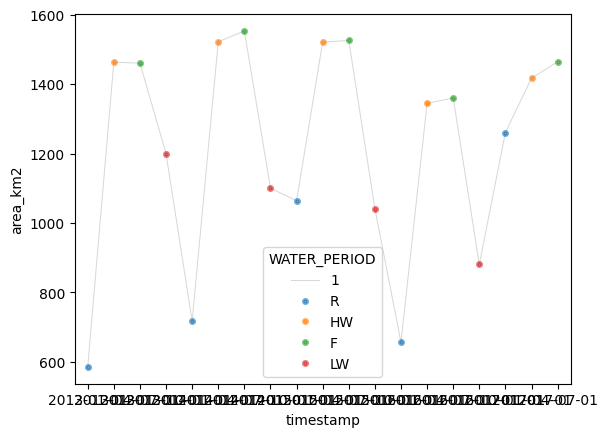

In [39]:
import seaborn as sns
sns.lineplot(data=teste, x ='timestamp',y= 'area_km2',  alpha=.3,color='gray',size=1)
sns.pointplot(data=teste, x ='timestamp',y= 'area_km2',markersize=3,linestyle='none',  alpha=.6,hue='WATER_PERIOD',native_scale=True)

In [44]:
col = merge_col.filterDate('2014-10-01','2015-01-01')
col.size()

In [45]:
Map = geemap.Map(basemap='HYBRID')
roi_points = ee.FeatureCollection('projects/ee-curuai/assets/curuai_points')
Map.centerObject(roi_points,10)

year = ee.Filter.eq('year',2014)
month = ee.Filter.eq('month_init',10)

Map.addLayer(monthly_area.filter(year).filter(month), {'bands':['red_mean','green_mean','blue_mean'], 'min':0,'max':0.02}, 'monthly composite')
Map.addLayer(col, {'bands':['red_mean','green_mean','blue_mean'], 'min':0,'max':0.02}, ' collection')

Map.addLayer(ee.FeatureCollection('projects/ee-curuai/assets/vectors/varzea_alagavel'),{'color':'red'},'limite varzea alagavel')

Map.addLayer(roi_points, {'color':'darkred'}, 'Data polygon');
Map

Map(center=[-2.184599717160098, -55.49304633852027], controls=(WidgetControl(options=['position', 'transparent…

# Import Model and Classify Images

In [ ]:
classifier = ee.Classifier.load('projects/ee-curuai/assets/RF_regressor')
classifier

In [ ]:
predictors = ['blue_mean', 'green_mean','red_mean', 'nir_mean']
ld7_classified = ld7_masked.select(predictors).map(lambda img: img.classify(classifier=classifier).copyProperties(img,['system:index','system:time_start']))
ld7_classified

In [ ]:
ld8_classified = ld8_masked.select(predictors).map(lambda img: img.classify(classifier=classifier).copyProperties(img,['system:index','system:time_start']))
ld8_classified

#Classification vizualization

## Import Points

In [ ]:
# points used for regression
reg_points = geemap.geojson_to_ee('/content/drive/MyDrive/CURUAI_PROCESS/regression_p.geojson')
reg_points_unique = reg_points.distinct('.geo')
reg_points_unique


## Sample images from regression points

In [ ]:
projection = ld8.first().select('red_mean').projection()

In [ ]:
ld7_sample = (ld7_classified
              .map(lambda img: img.addBands(ee.Image(ee.Number(img.get('system:time_start')))).rename(['SPM_img','img_date']))
              .map(lambda img: img.sampleRegions(collection = reg_points_unique, scale=30, projection=projection,geometries=False))
              .flatten()
              .map(lambda feat: feat.set('img_datetime',ee.Date(feat.get('img_date')).format('yyyy-MM-dd HH:mm:ss'))))
ld7_sample.select(['SPM_img','img_datetime']).limit(10)

In [ ]:
ld8_sample = (ld8_classified
              .map(lambda img: img.addBands(ee.Image(ee.Number(img.get('system:time_start')))).rename(['SPM_img','img_date']))
              .map(lambda img: img.sampleRegions(collection = reg_points_unique, scale=30, projection=projection,geometries=False))
              .flatten()
              .map(lambda feat: feat.set('img_datetime',ee.Date(feat.get('img_date')).format('yyyy-MM-dd HH:mm:ss'))))
ld8_sample.select(['SPM_img','img_datetime']).size()

In [ ]:
obs_points = gpd.read_file('/content/drive/MyDrive/CURUAI_PROCESS/regression_p.geojson')
obs_points

LATITUDE  LONGITUDE    SPM  SPM_predicted WATER_PERIOD  blue_mean  \
0   -2.196960 -55.299530  34.40      54.698376            R   0.016988   
1   -2.221738 -55.270194  44.40      47.285001            R   0.017570   
2   -2.209570 -55.347110  44.80      36.468949            R   0.014560   
3   -2.262023 -55.456187  45.20      65.154042            R   0.031565   
4   -2.133265 -55.488798  39.20      44.829901            R   0.021785   
..        ...        ...    ...            ...          ...        ...   
182 -2.180361 -55.016444  57.00      62.350335           HW   0.019383   
183 -2.173257 -55.372851  14.50      21.803986           HW   0.014880   
184 -2.135144 -55.370602  19.00      23.679412           HW   0.012534   
185 -2.113672 -55.370602  25.75      28.166720           HW   0.004243   
186 -2.245385 -55.240660  12.20      26.927892           HW   0.015489   

               datetime  green_mean  nir_mean  red_mean  \
0   2013-03-09 11:20:00    0.027905  0.016161  0.036151   
1   2013-03-09 13:00:00    0.029232  0.013234  0.034852   
2   2013-03-09 14:35:00    0.020075  0.010206  0.024131   
3   2013-03-11 08:00:00    0.039040  0.020332  0.043538   
4   2013-03-11 13:00:00    0.032779  0.014011  0.038842   
..                  ...         ...       ...       ...   
182 2017-04-10 18:00:00    0.033635  0.016626  0.046282   
183 2017-04-11 14:30:00    0.021639  0.005093  0.024721   
184 2017-04-11 15:15:00    0.020394  0.004060  0.023798   
185 2017-04-11 15:50:00    0.014249  0.007008  0.018634   
186 2017-04-18 13:00:00    0.025040  0.007207  0.025451   

                       geometry  
0    POINT (-55.29953 -2.19696)  
1    POINT (-55.27019 -2.22174)  
2    POINT (-55.34711 -2.20957)  
3    POINT (-55.45619 -2.26202)  
4     POINT (-55.4888 -2.13326)  
..                          ...  
182  POINT (-55.01644 -2.18036)  
183  POINT (-55.37285 -2.17326)  
184   POINT (-55.3706 -2.13514)  
185   POINT (-55.3706 -2.11367)  
186  POINT (-55.24066 -2.24538)  

[187 rows x 11 columns]

In [ ]:
ld8_pred = ee.data.computeFeatures({
    'expression': ld8_sample.select(['SPM_img','img_datetime']),
    'fileFormat': 'PANDAS_DATAFRAME'
})

In [ ]:
ld7_pred = ee.data.computeFeatures({
    'expression': ld7_sample.select(['SPM_img','img_datetime']),
    'fileFormat': 'PANDAS_DATAFRAME'
})

In [ ]:
ld7_pred = ld7_pred.astype({'SPM_img': 'float64'})
ld8_pred = ld8_pred.astype({'SPM_img': 'float64'})


In [ ]:
ld7_pred['img_datetime']= pd.to_datetime(ld7_pred['img_datetime'])
ld8_pred['img_datetime']= pd.to_datetime(ld8_pred['img_datetime'])

In [ ]:
df_pred = pd.concat([ld7_pred,ld8_pred]).sort_values('img_datetime')
df_pred.dtypes

geo                     object
SPM_img                float64
img_datetime    datetime64[ns]
dtype: object

In [ ]:
df_pred

geo    SPM_img        img_datetime
152   None  50.771477 2013-03-16 13:50:07
148   None  81.416534 2013-03-16 13:50:07
149   None  50.771477 2013-03-16 13:50:07
150   None  50.674473 2013-03-16 13:50:07
151   None  63.578747 2013-03-16 13:50:07
...    ...        ...                 ...
6009  None  26.321892 2017-09-19 13:56:58
6000  None  50.480186 2017-09-19 13:56:58
126   None  33.177132 2017-09-28 13:50:48
125   None  93.894180 2017-09-28 13:50:48
124   None  33.177132 2017-09-28 13:50:48

[13229 rows x 3 columns]

<Axes: xlabel='img_datetime', ylabel='SPM_img'>

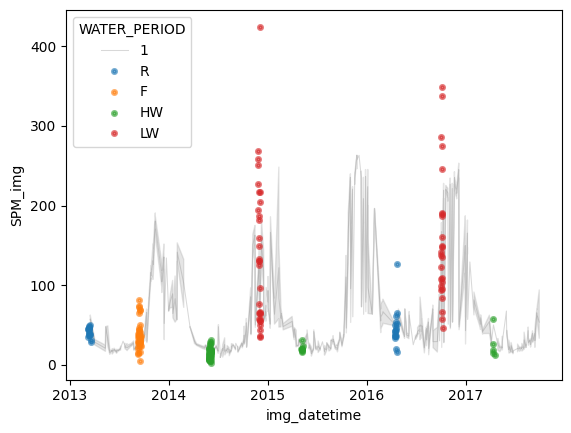

In [ ]:
import seaborn as sns
sns.lineplot(data=df_pred, x ='img_datetime',y= 'SPM_img',  alpha=.3,color='gray',size=1)
sns.pointplot(data=obs_points, x ='datetime',y= 'SPM',markersize=3,linestyle='none',  alpha=.6,hue='WATER_PERIOD',native_scale=True)

In [ ]:
Map = geemap.Map(basemap='HYBRID')
roi_points = ee.FeatureCollection('projects/ee-curuai/assets/curuai_points')
Map.centerObject(roi_points,10)
imgld7 = ee.Filter.eq('system:index','BOA_LE07_228061_20130604')
imgld8 = ee.Filter.eq('system:index','BOA_LC08_228061_20140615')

Map.addLayer(ld7.filter(imgld7).first(), {'bands':['red_mean','green_mean','blue_mean'], 'min':0,'max':0.02}, 'ld7')
Map.addLayer(ld8.filter(imgld8).first(), {'bands':['red_mean','green_mean','blue_mean'], 'min':0,'max':0.02}, 'ld8')

Map.addLayer(ld7_masked.filter(imgld7).first(), {'bands':['red_mean','green_mean','blue_mean'], 'min':0,'max':0.02}, 'ld7 masked')
Map.addLayer(ld8_masked.filter(imgld8).first(), {'bands':['red_mean','green_mean','blue_mean'], 'min':0,'max':0.02}, 'ld8 masked')


Map.addLayer(ld7_classified.filter(imgld7).first(), {'palette':['#ffffb2','#fecc5c','#fd8d3c','#e31a1c'], 'min':0,'max':150}, 'classification LD7')
Map.addLayer(ld8_classified.filter(imgld8).first(), {'palette':['#ffffb2','#fecc5c','#fd8d3c','#e31a1c'], 'min':0,'max':150}, 'classification LD8')

Map.addLayer(varzea_gee,{'color':'red'},'limite varzea alagavel')

Map.addLayer(roi_points, {'color':'darkred'}, 'Data polygon');
Map

Map(center=[-2.184599717160098, -55.49304633852027], controls=(WidgetControl(options=['position', 'transparent…